In [7]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

# Курсовой проект по теме Библиотеки Python для Data Science 

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [72]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [73]:

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [74]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [75]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Обзор данных, проверка соответсвия train  и test

In [76]:
df_train=pd.read_csv(TRAIN_DATASET_PATH)
df_test=pd.read_csv(TEST_DATASET_PATH)

In [77]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [78]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [79]:
#выделим категорийные данные
STR_COLUMNS=['Home Ownership','Years in current job','Purpose','Term']

In [80]:
for column_name in STR_COLUMNS:
    values=df_train[column_name].value_counts().count()-df_test[column_name].value_counts().count()
    if(values!=0):
        print(column_name, values)
        
        print(df_train[column_name].value_counts()-df_test[column_name].value_counts()) 
        

Purpose 1
business loan             99.0
buy a car                 62.0
buy house                 15.0
debt consolidation      3971.0
educational expenses       7.0
home improvements        272.0
major purchase            31.0
medical bills             44.0
moving                    10.0
other                    425.0
renewable energy           NaN
small business            21.0
take a trip               23.0
vacation                   5.0
wedding                   13.0
Name: Purpose, dtype: float64


In [81]:
df_train['Purpose'].value_counts()['renewable energy']

2

Поле 'renewable energy' отсутствует в test данных при этом число этих данных = 2 поэтому данный признак можно удалить. 

In [82]:
df_train=df_train[df_train['Purpose']!='renewable energy']

# Обработка выбросов

In [83]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7498.000000,7498.000000,7498.000000,7.498000e+03,7498.000000,3418.000000,7484.000000,7.498000e+03,7.498000e+03,7498.000000,5943.000000,7498.000000
mean,1.366392e+06,0.030141,11.131635,18.315617,9.453422e+05,0.170045,34.695436,0.117183,1.187631e+07,2.898775e+05,18317.165511,1151.087498,0.281542
std,8.453392e+05,0.271639,4.908569,7.041841,1.602835e+07,0.498657,21.691346,0.347233,3.192980e+07,3.178999e+05,11927.166233,1604.451418,0.449781
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792570e+05,0.000000,16.000000,0.000000,1.801855e+05,1.142802e+05,10071.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781810e+05,0.000000,32.000000,0.000000,3.096060e+05,2.093420e+05,16080.000000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.936445e+05,0.000000,50.000000,0.000000,5.202340e+05,3.604348e+05,23830.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [84]:
NUMBER_COLUMNS=df_train.columns.drop(STR_COLUMNS)

Annual Income


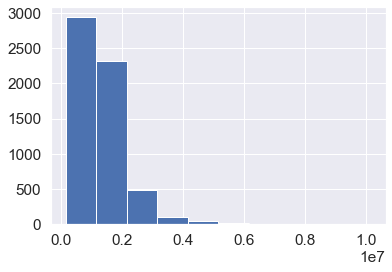

Tax Liens


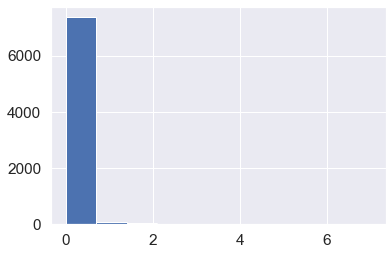

Number of Open Accounts


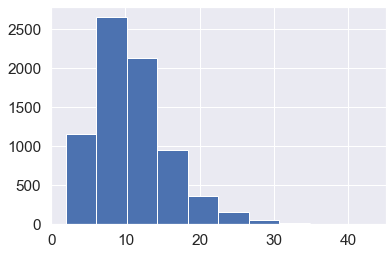

Years of Credit History


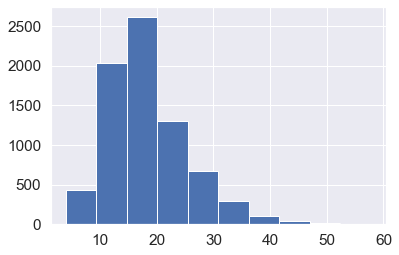

Maximum Open Credit


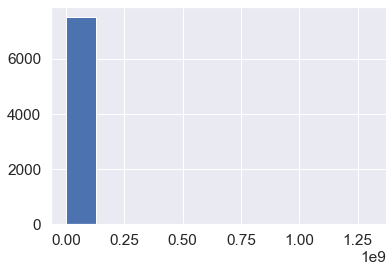

Number of Credit Problems


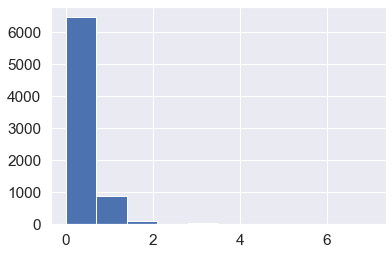

Months since last delinquent


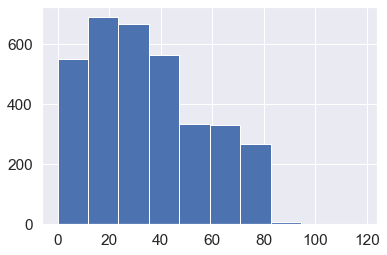

Bankruptcies


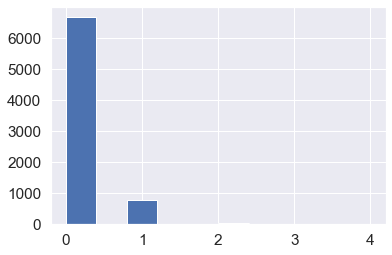

Current Loan Amount


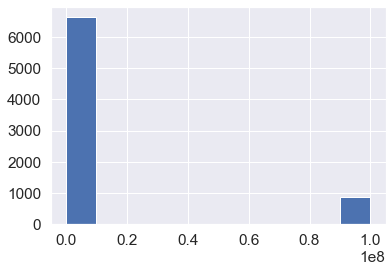

Current Credit Balance


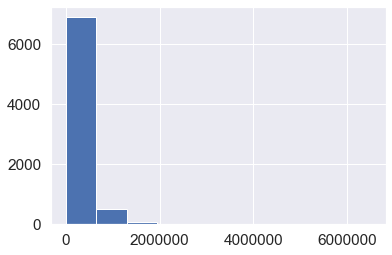

Monthly Debt


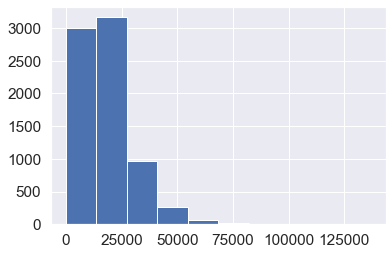

Credit Score


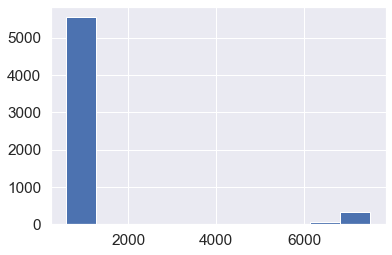

Credit Default


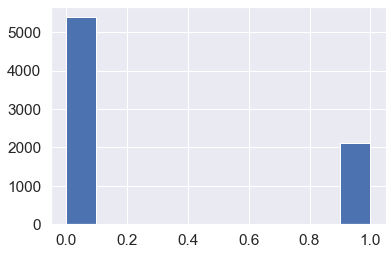

In [85]:

for column in NUMBER_COLUMNS:
    df_train[column].hist()
    print(column)
    plt.show()

In [86]:
df_train.loc[df_train['Tax Liens']>6,'Tax Liens']=df_train['Tax Liens'].mode()[0]
df_train.loc[df_train['Months since last delinquent']>110,'Months since last delinquent']=df_train['Months since last delinquent'].mode()[0]
#df_train.loc[df_train['Bankruptcies']>3,'Bankruptcies']=df_train['Bankruptcies'].mode()[0]
#df_train.loc[df_train['Annual Income']>8e+06,'Annual Income']=df_train['Annual Income'].mode()[0]
#df_train.loc[df_train['Monthly Debt']>100000,'Monthly Debt']=df_train['Monthly Debt'].mode()[0]
#df_train.loc[df_train['Current Credit Balance']>5000000,'Current Credit Balance']=df_train['Current Credit Balance'].mode()[0]
#df_train.loc[df_train['Current Loan Amount']>=99999999.0,'Current Loan Amount']=df_train['Current Loan Amount'].median()
df_train.loc[df_train['Years in current job']=='10+ years','Years in current job']='10years'
df_train.loc[df_train['Years in current job']=='< 1 year','Years in current job']='0years'

# Обработка пропусков

In [87]:
len(df_train)-df_train.count()

Home Ownership                     0
Annual Income                   1555
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4080
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1555
Credit Default                     0
dtype: int64

In [88]:
def fill_Nan_median(dataset,columns):
    for column_name in columns:
        dataset.loc[dataset[column_name].isna(),column_name]=dataset[column_name].median()

def fill_Nan_0(dataset,columns):
    for column_name in columns:
        dataset.loc[dataset[column_name].isna(),column_name]=0     

def fill_Nan_str_max(dataset,columns):
    for column_name in columns:
        dataset.loc[dataset[column_name].isna(),column_name]=dataset[column_name].value_counts().index[0]  

преобразуем строковые признаки 

In [89]:
def prepare_data_set(data_set,str_columns):
    COLUMN_Median=['Annual Income','Bankruptcies','Credit Score'] ##'Years in current job',
    COLUMN_0=['Months since last delinquent']
    fill_Nan_median(data_set,COLUMN_Median)
    fill_Nan_0(data_set,COLUMN_0)
    fill_Nan_str_max(data_set,['Years in current job'])
    
    for column_name in str_columns:
        val=data_set[column_name].value_counts().index
        for index in val:
            data_set.loc[data_set[column_name]==index,index]=1

    data_set=data_set.fillna(0)
    data_set=data_set.drop(str_columns,1) 
    return data_set

In [90]:
df_train=prepare_data_set(df_train,STR_COLUMNS)

In [91]:
df_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default', 'Home Mortgage',
       'Rent', 'Own Home', 'Have Mortgage', '10years', '2 years', '3 years',
       '0years', '5 years', '1 year', '4 years', '6 years', '7 years',
       '8 years', '9 years', 'debt consolidation', 'other',
       'home improvements', 'business loan', 'buy a car', 'medical bills',
       'major purchase', 'take a trip', 'buy house', 'small business',
       'wedding', 'moving', 'educational expenses', 'vacation', 'Short Term',
       'Long Term'],
      dtype='object')

# Анализ данных

In [92]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [93]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2111
Name: Credit Default, dtype: int64

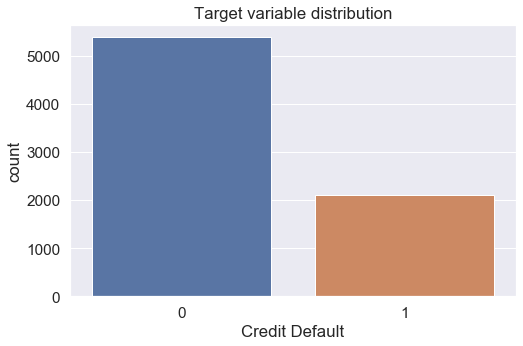

In [94]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

относительно целевой переменной данные не сбалансированы

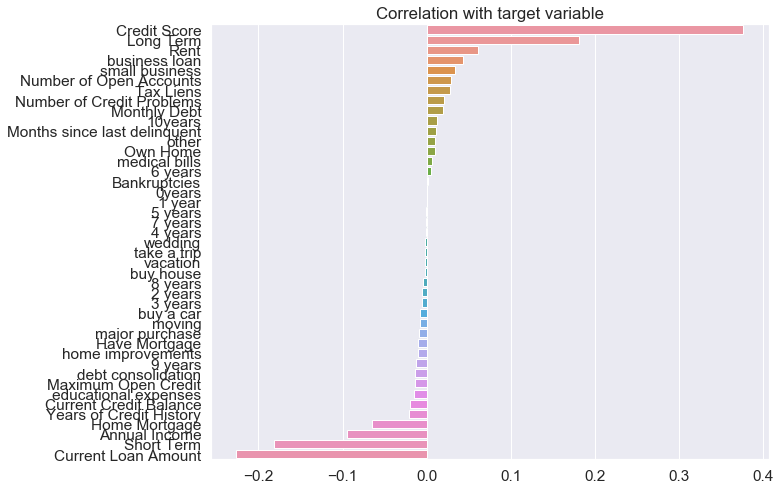

In [95]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

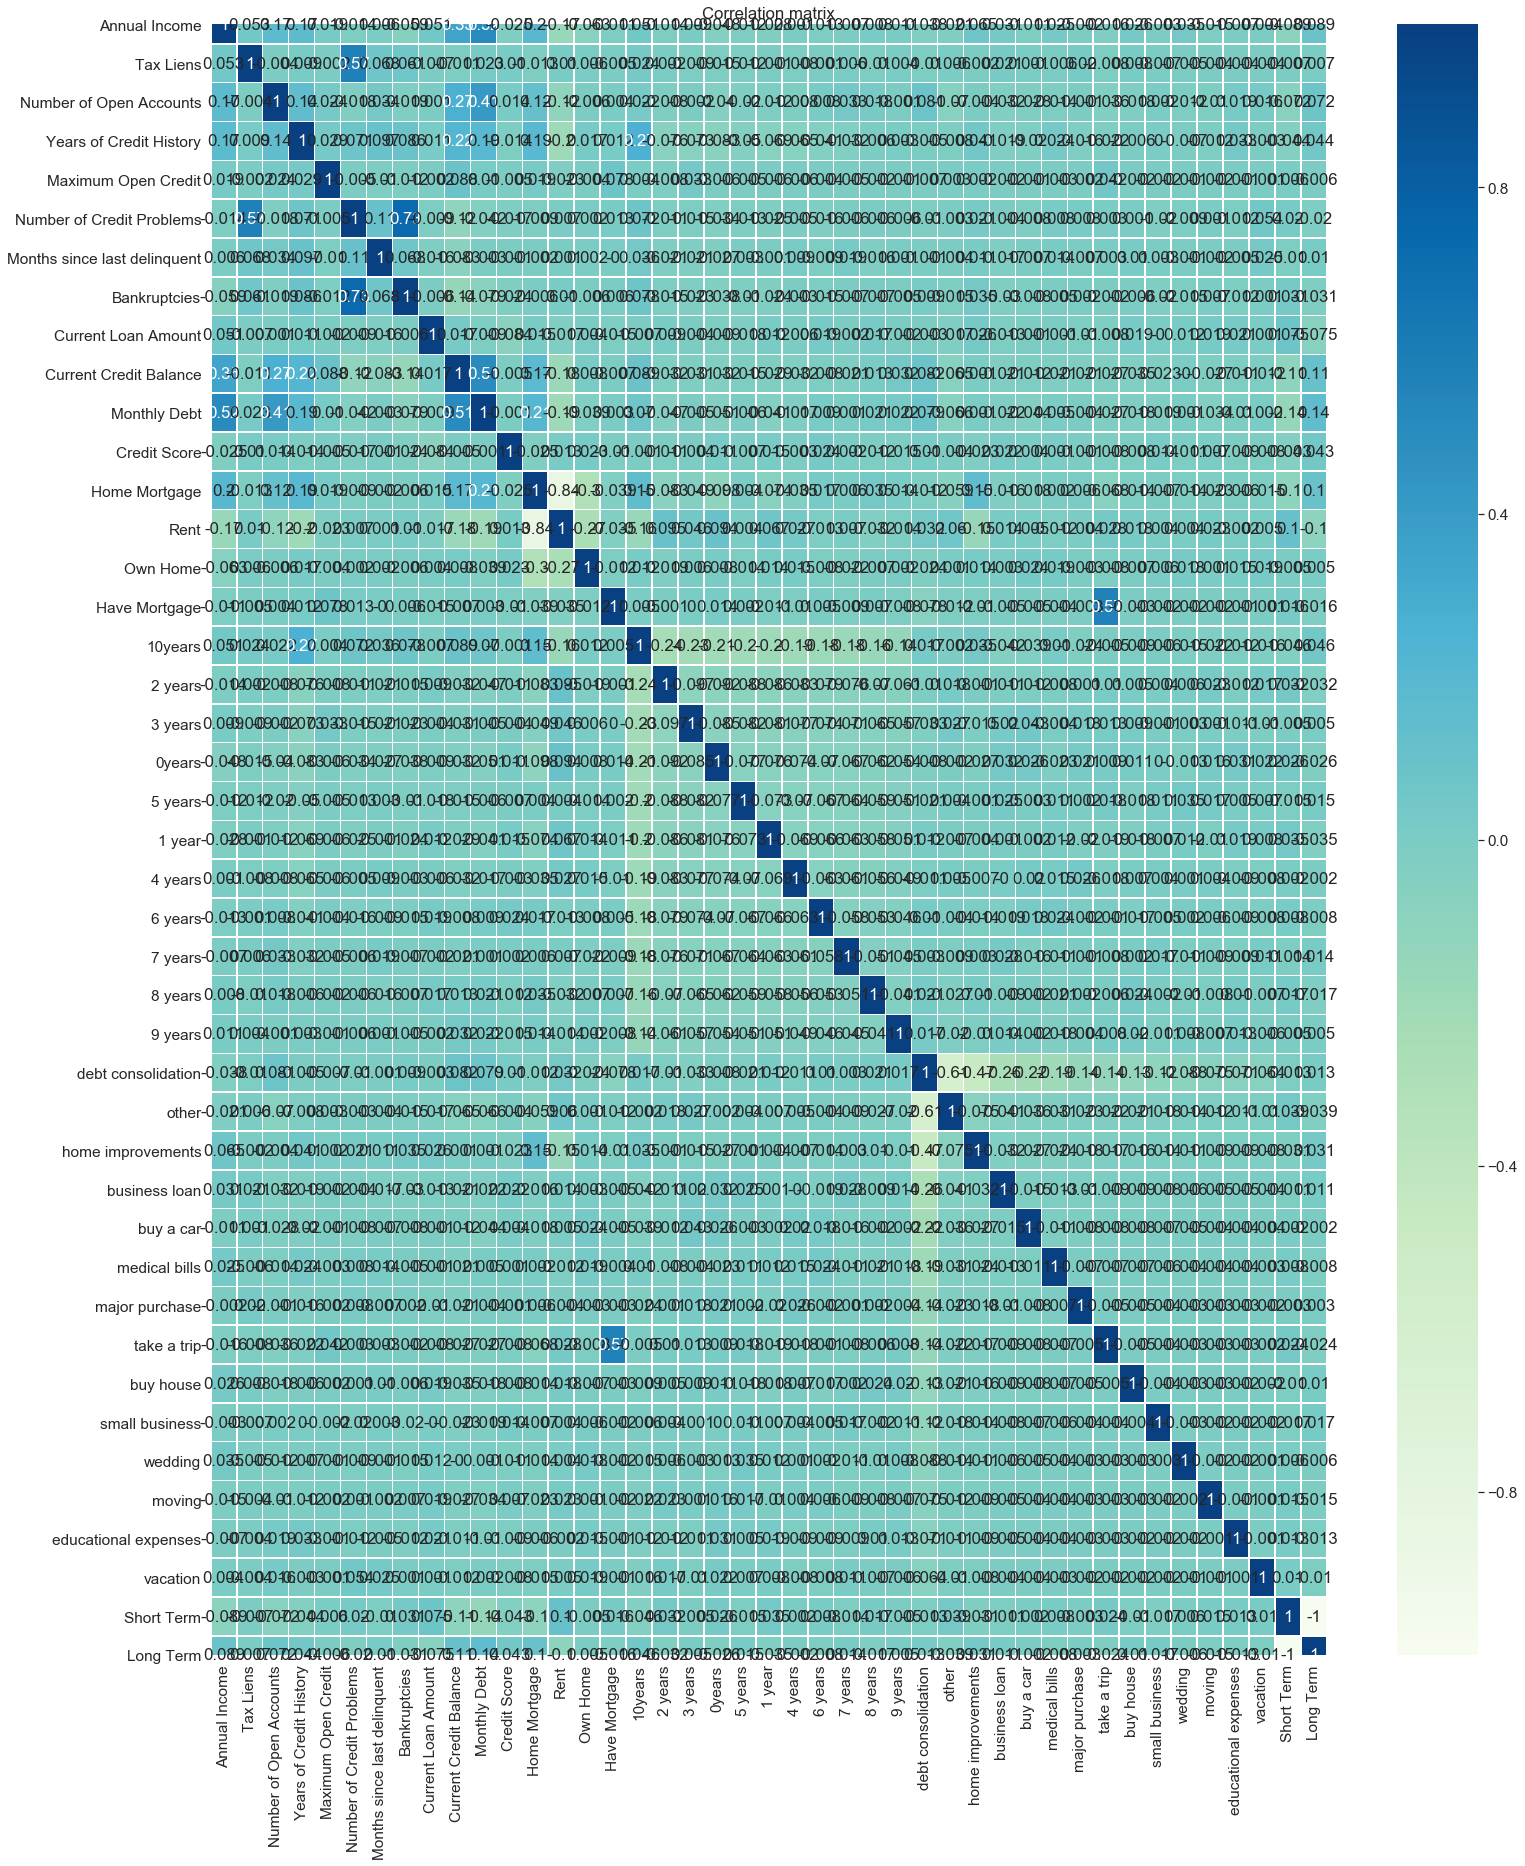

In [96]:
plt.figure(figsize = (25,30))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [97]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
NUMBER_COLUMNS=NUMBER_COLUMNS.drop([TARGET_NAME] )

In [98]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMBER_COLUMNS] = scaler.fit_transform(df_norm[NUMBER_COLUMNS])

df_train = df_norm.copy()

In [99]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

# Балансировка

In [100]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [101]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\Cats\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
C:\Users\Cats\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    4030
1    3186
Name: Credit Default, dtype: int64

In [102]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

# Выбор модели

In [103]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [104]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4030
           1       0.93      0.85      0.89      3186

    accuracy                           0.91      7216
   macro avg       0.91      0.90      0.91      7216
weighted avg       0.91      0.91      0.91      7216

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1357
           1       0.56      0.47      0.51       518

    accuracy                           0.75      1875
   macro avg       0.68      0.66      0.67      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1163  194
1                274  244


# Снижение степени переобучения

Подбором параметров CatBoot Наилучшие результаты при n_estimators=500, max_depth=3,l2_leaf_reg=5,
                                      learning_rate=0.04

Добавление L2 регурилизации

In [105]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,l2_leaf_reg=5,
                                      learning_rate=0.04,silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4030
           1       0.79      0.62      0.70      3186

    accuracy                           0.76      7216
   macro avg       0.77      0.75      0.75      7216
weighted avg       0.77      0.76      0.76      7216

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1357
           1       0.55      0.52      0.54       518

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.75      0.75      0.75      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1136  221
1                248  270


# Выбор порога вероятности для определения класса

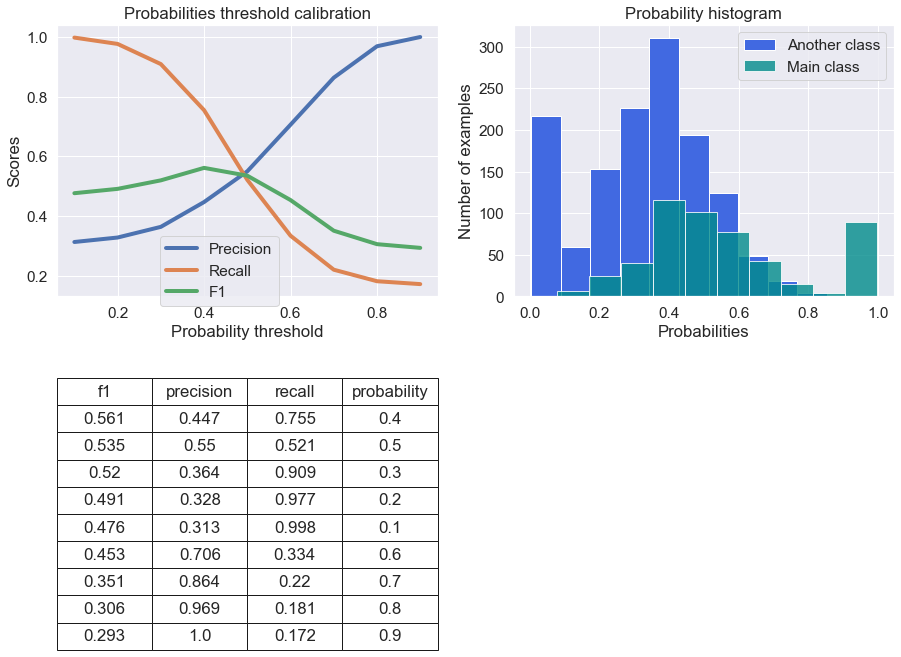

In [106]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

примерно 0,48

# Важность признаков

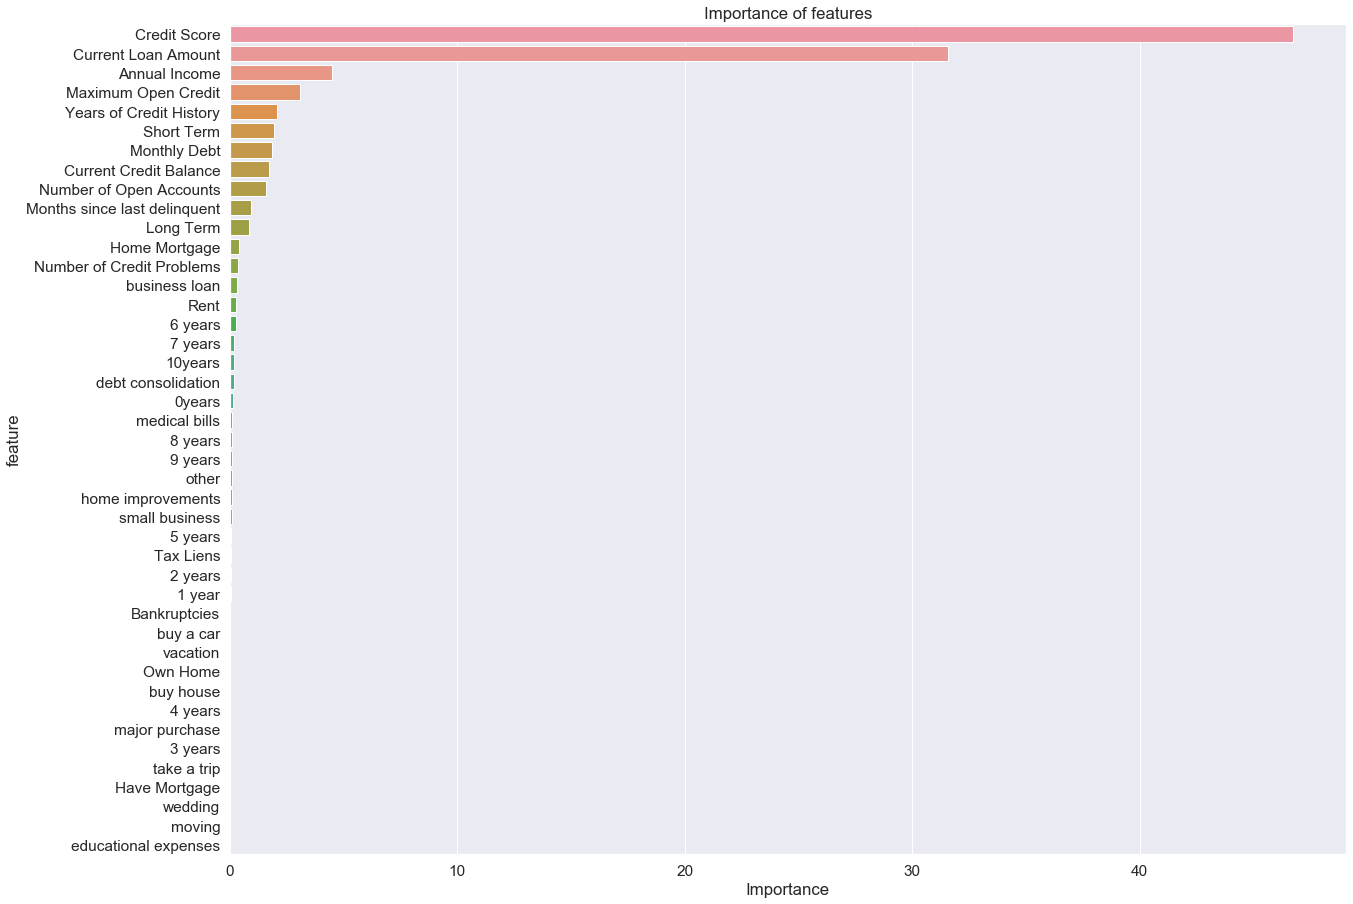

In [107]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=20)

In [108]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Short Term',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Long Term',
 'Home Mortgage',
 'Number of Credit Problems',
 'business loan',
 'Rent',
 '6 years',
 '7 years',
 '10years',
 'debt consolidation',
 '0years']

# Финальная модель

In [109]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,l2_leaf_reg=5, learning_rate=0.04,
                                      silent=True, random_state=50,)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4030
           1       0.79      0.61      0.69      3186

    accuracy                           0.76      7216
   macro avg       0.77      0.74      0.75      7216
weighted avg       0.76      0.76      0.75      7216

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1357
           1       0.55      0.52      0.54       518

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.75      0.75      0.75      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1142  215
1                250  268


f1-score  для базового класса = 0.54 весьма неплохо.

# Подготовка тестовых данных, вывод прогноза

In [110]:
df_test.loc[df_test['Years in current job']=='10+ years','Years in current job']='10years'
df_test.loc[df_test['Years in current job']=='< 1 year','Years in current job']='0years'

In [111]:
df_test=prepare_data_set(df_test,STR_COLUMNS)

In [112]:
scaler = StandardScaler()

df_norm = df_test.copy()
df_norm[NUMBER_COLUMNS] = scaler.fit_transform(df_norm[NUMBER_COLUMNS])

df_test = df_norm.copy()

In [113]:
y_pred=final_model.predict(df_test[important_features_top])

In [114]:
df_test['Credit Default']=y_pred

In [115]:
df_test.to_csv(r'Bolshakov_D_A_predictions.csv',columns={'Credit Default'},header=True,index=True)